# Gaia DR2 variability lightcurves
### Part III: What do the Gaia lightcurves look like?

gully  
May 2, 2018

In [1]:
# %load /Users/obsidian/Desktop/defaults.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
! du -hs ../data/dr2/Gaia/gdr2/light_curves/csv/

2.5G	../data/dr2/Gaia/gdr2/light_curves/csv/


In [3]:
df0 = pd.read_csv('../data/dr2/Gaia/gdr2/light_curves/csv/light_curves_1042504286338226688_1098703830327377408.csv.gz')

In [4]:
df0.shape

(124244, 12)

In [5]:
df0.head(2)

,source_id,transit_id,band,time,mag,flux,flux_error,flux_over_error,rejected_by_photometry,rejected_by_variability,other_flags,solution_id
0,1042504286338226688,17268269051856559,G,1709.128793,18.523283,734.569815,18.542235,39.616035,False,False,4199041,369295549951641967
1,1042504286338226688,17278009813791101,G,1709.304988,18.465245,774.904573,10.693891,72.462364,False,False,1,369295549951641967


In [6]:
df0.tail(2)

,source_id,transit_id,band,time,mag,flux,flux_error,flux_over_error,rejected_by_photometry,rejected_by_variability,other_flags,solution_id
124242,1098703830327377408,51230417219907812,RP,2323.317847,17.394265,885.242359,36.405005,24.316502,False,False,0,369295549951641967
124243,1098703830327377408,51234509472063639,RP,2323.391849,17.326266,942.457017,42.092763,22.390001,False,False,0,369295549951641967


Ok, this *flat file* is just what we want.  It contains the flux as a function of time for unique sources, with additional metadata flags.

In [7]:
import glob

In [8]:
fns = glob.glob('../data/dr2/Gaia/gdr2/light_curves/csv/light_curves_*.csv.gz')

In [9]:
n_files = len(fns)

In [10]:
n_files

551

It looks like the filename encodes the range of sources housed in each file.  Let's extract that metadata without having to read the files.

In [11]:
fn_df = pd.DataFrame({'fn':fns})
fn_df.head()

,fn
0,../data/dr2/Gaia/gdr2/light_curves/csv/light_c...
1,../data/dr2/Gaia/gdr2/light_curves/csv/light_c...
2,../data/dr2/Gaia/gdr2/light_curves/csv/light_c...
3,../data/dr2/Gaia/gdr2/light_curves/csv/light_c...
4,../data/dr2/Gaia/gdr2/light_curves/csv/light_c...


In [12]:
fn_df['basename'] = fn_df.fn.str.split('/').str[-1].str.split('light_curves_').str[-1].str.split('.csv.gz').str[0]

In [13]:
fn_df['low'] = fn_df.basename.str.split('_').str[0].astype(np.int64)
fn_df['high'] = fn_df.basename.str.split('_').str[1].astype(np.int64)

Now we can make a mask to find which file we want.  Let's say we want the Gaia source: 66511970924353792

In [14]:
source = 66511970924353792
k2_source = 211059767
gaia_period = 0.771791

In [15]:
mask = (source > fn_df.low) & (source < fn_df.high) 

In [16]:
mask.sum()

1

In [17]:
path = fn_df[mask].fn.values[0]

In [18]:
df_lc = pd.read_csv(path)

In [19]:
df_lc = df_lc[df_lc.source_id==source]

In [20]:
df_lc.shape

(100, 12)

Not bad! We have a 96 point lightcurve!

In [21]:
df_lc.band.value_counts()

G     36
RP    33
BP    31
Name: band, dtype: int64

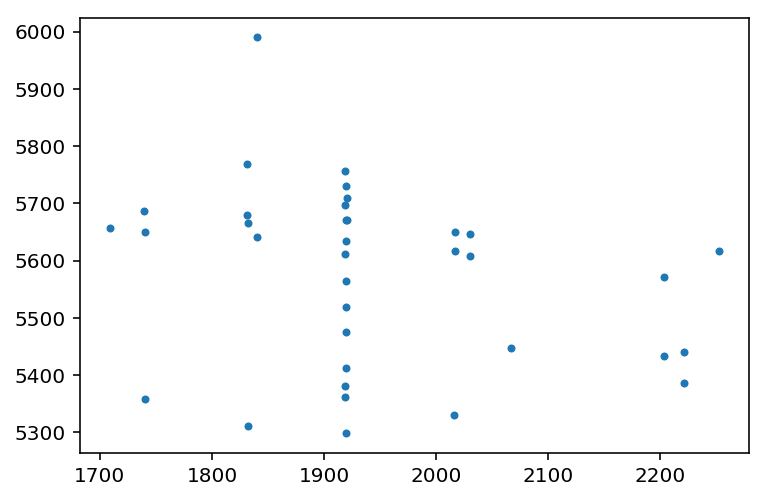

In [22]:
gi = df_lc.band == 'G'
plt.plot(df_lc.time[gi], df_lc.flux[gi], '.')

The Gaia photometry is taken over 500 days!  The mean starspot coverage fraction is not expected to be coherent over such large timescales.  There's a portion of the data that is taken contiguously.  Let's highlight those.

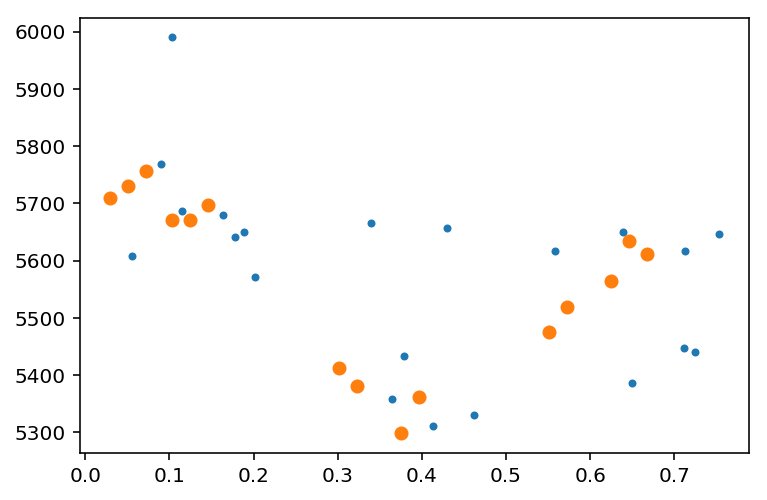

In [23]:
plt.plot(np.mod(df_lc.time[gi], gaia_period), df_lc.flux[gi], '.')
alt = gi & (df_lc.time >1900) & (df_lc.time<1950)
plt.plot(np.mod(df_lc.time[alt], gaia_period), df_lc.flux[alt], 'o')

Seems plausible...

In [24]:
30.0*4000

120000.0

In [25]:
from lightkurve import KeplerTargetPixelFile

In [26]:
tpf = KeplerTargetPixelFile.from_archive(k2_source)

Found 1 File(s)
INFO: Found cached file ./mastDownload/K2/ktwo211059767-c04_lc/ktwo211059767-c04_lpd-targ.fits.gz with expected size 3808135. [astroquery.query]


In [27]:
k2_lc = tpf.to_lightcurve()
k2_lc = k2_lc[(k2_lc.flux == k2_lc.flux) & np.isfinite(k2_lc.flux) & (k2_lc.flux_err == k2_lc.flux_err)]
tpf.interact(lc=k2_lc)

Loading BokehJS ...

A Jupyter Widget

A Jupyter Widget

The full K2 postage stamp contains another source, which would have easily been separated in Gaia.

In [28]:
# %load https://www.astroml.org/gatspy/periodic/lomb_scargle-1.py

In [29]:
from gatspy import periodic

In [30]:
model = periodic.LombScargle()
model.optimizer.period_range = (0.5, 1)
model.fit(k2_lc.time, k2_lc.flux, k2_lc.flux_err)

[Text(0,0.5,'Lomb Scargle Power'), Text(0.5,0,'period (days)')]

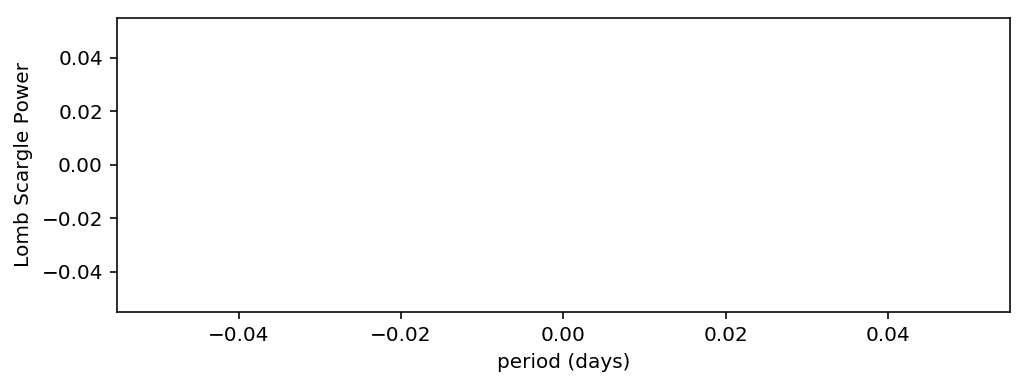

In [31]:
periods = np.linspace(0.5, 1, 10000)

import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    scores = model.score(periods)

# Plot the results
fig, ax = plt.subplots(figsize=(8, 3))
fig.subplots_adjust(bottom=0.2)
ax.plot(periods, scores)
ax.set(xlabel='period (days)', ylabel='Lomb Scargle Power')

In [32]:
model.best_period

Finding optimal frequency:
 - Estimated peak width = 0.0886
 - Using 5 steps per peak; omega_step = 0.0177
 - User-specified period range:  0.5 to 1
 - Computing periods at 356 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/Users/obsidian/anaconda3/lib/python3.6/site-packages/gatspy/periodic/_least_squares_mixin.py:79: RuntimeWarning: divide by zero encountered in true_divide
  P = chi2_0_minus_chi2 / chi2_ref


1.002829744214618

Gaia has 0.771791, close!

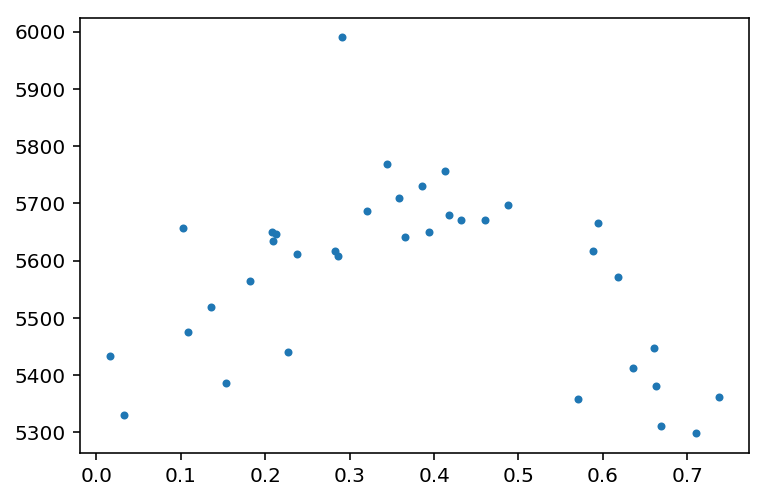

In [33]:
plt.plot(np.mod(df_lc.time[gi], 0.7779122), df_lc.flux[gi], '.')

Maybe slightly better coherence than the Gaia-based estimate.